In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import networkx as nx
import seaborn as sns

In [2]:
df = pd.read_csv("../Datasets/flavornet_dataset.csv")

In [3]:
df = df.dropna() # Drop N/A values
print("Number of odorants is %d" % len(df))
print("\n")
print("Sample of the dataset")
print(df.head())

Number of odorants is 634


Sample of the dataset
          Odorant                      Odor Unnamed: 2    exactmw  \
0  trimethylamine                      fish     CN(C)C  59.073499   
1         ethanal            pungent, ether       CC=O  44.026215   
2    methanethiol  sulfur, gasoline, garlic         CS  48.003371   
3        propanal          solvent, pungent      CCC=O  58.041865   
4         pentane                    alkane      CCCCC  72.093900   

   lipinskiHBA  lipinskiHBD  NumRotatableBonds  NumHBD  NumHBA  \
0          1.0          0.0                0.0     0.0     1.0   
1          1.0          0.0                0.0     0.0     1.0   
2          0.0          0.0                0.0     1.0     1.0   
3          1.0          0.0                1.0     0.0     1.0   
4          0.0          0.0                2.0     0.0     0.0   

   NumHeteroatoms  ...  NumSaturatedHeterocycles NumAliphaticHeterocycles  \
0             1.0  ...                       0.0             

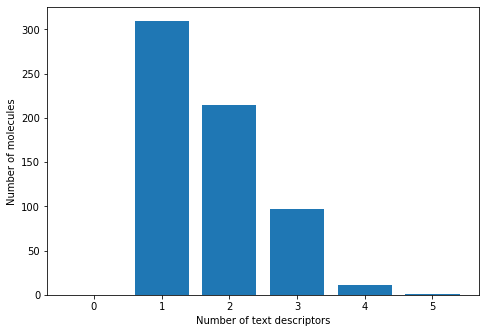

In [4]:
# Bar graph to view the distribution of number of descriptors per molecule

num_descriptors = [0]*6 # array with the distributions. Max 5 descriptors per molecule
odors_series = df['Odor']
odors_series = odors_series.str.split(",") # Pandas series method to split on a delimiter

def get_odor_distribution(array):
    # Input is a row of the Series containing descriptors
    number_of_descriptors = len(array)
    num_descriptors[number_of_descriptors] += 1

odors_series.apply(get_odor_distribution)

indices = [x for x in range(0, len(num_descriptors))]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(indices,num_descriptors)
plt.xlabel("Number of text descriptors")
plt.ylabel("Number of molecules")
plt.show()

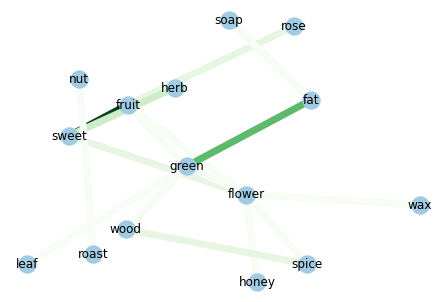

In [5]:
# Code to visualize the connection strength between descriptors

edge_dict = {} # Dictionary of edges and corresponding counts
total_pairs = 0
def create_edge_list(array):
    global total_pairs
    array = sorted([name.strip().strip(',').lower() for name in array])
    if len(array) > 1:
        # If there is more than one descriptor
        for pair in itertools.combinations(array, 2):
            total_pairs += 1
            final_pair = pair[0] + "," + pair[1]
            edge_dict[final_pair] = edge_dict.get(final_pair, 0) + 1 # Update dictionary value

odors_series.apply(create_edge_list) # Create edge list from data

# Create a graph object #
connection_strength_graph = nx.Graph()

# Now need to update dictionary counts as weights by dividing by total
for edge in edge_dict:
    if edge_dict[edge] > 3:
        # Too many nodes make it hard to visualize the graph; removing edges that don't occur more than thrice
        edge_list = edge.split(',')
        weight = edge_dict[edge]/total_pairs
        connection_strength_graph.add_edge(edge_list[0], edge_list[1], weight=weight) # Add this edge to the graph


final_edges,final_weights = zip(*nx.get_edge_attributes(connection_strength_graph,'weight').items())
nx.draw(connection_strength_graph, node_color='#A0CBE2', edge_color=final_weights, width=7, edge_cmap=plt.cm.Greens, with_labels=True)
plt.show()

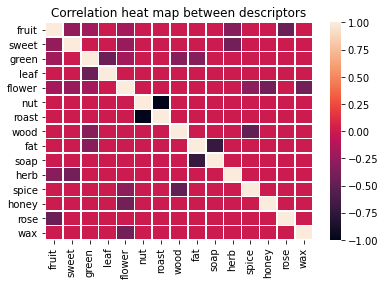

In [6]:
# Code to generate a correlation heat map between the most frequent pairs of descriptors

corr_matrix = nx.normalized_laplacian_matrix(connection_strength_graph, weight=final_edges)
heat_map_labels = connection_strength_graph.nodes()
ax = sns.heatmap(corr_matrix.toarray(), xticklabels=heat_map_labels, yticklabels=heat_map_labels, linewidth=0.5)
ax.set_title('Correlation heat map between descriptors')
plt.show()

In [7]:
# Code to get the unique labels and their counts in the dataset
# Also to investigate the distribution of descriptors among single-descriptor molecules

label_counts = {} # Dict of the each label and the number of times it appears in the dataset
single_descriptor_molecules = {} # Dict of the labels that appear for molecules that only have one descriptor and their counts

def get_labels_counts(array):
    global single_descriptor_molecules
    array = [name.strip().strip(',').lower() for name in array]
    if len(array) == 1:
        # Descriptor distribution among single-descriptor molecules
        single_descriptor_molecules[array[0]] = label_counts.get(array[0], 0) + 1

    for label in array:
        label_counts[label] = label_counts.get(label, 0) + 1  # Update label count accordingly

odors_series.apply(get_labels_counts)

print("The number of unique labels in the original dataset is %d" % len(label_counts))

The number of unique labels in the original dataset is 189


In [8]:
unique_descriptors = []
for descriptor in label_counts:
    if label_counts[descriptor] == 1:
        try:
            # Finds descriptors that appear alone and only once in the dataset
            if single_descriptor_molecules[descriptor] == 1:
                unique_descriptors.append(descriptor)
        except KeyError:
            pass
print ("The unique descriptors are \n")
print (unique_descriptors)

The unique descriptors are 

['alkaline', 'sour', 'pesticide', 'marshmallow', 'hyacinth', 'paper', 'bitter almond', 'menthol', 'watermelon', 'tar', 'urine', 'grapefruit', 'hummus', 'plum', 'mandarin', 'jasmine', 'muguet', 'apricot', 'almond shell']


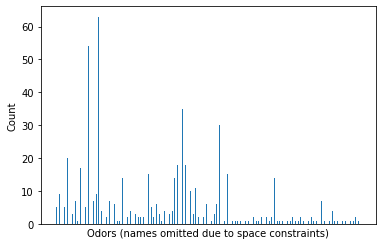

In [9]:
# Bar graph showing the counts for each label
ax2 = plt.subplot()
ax2.bar(list(label_counts.keys()),list(label_counts.values()), align='edge', width=0.3)

# To make the x-axis labels more readable #
"""
N = len(label_counts)
plt.grid()

plt.gca().margins(x=0)
plt.gcf().canvas.draw()
tl = plt.gca().get_xticklabels()
maxsize = max([t.get_window_extent().width for t in tl])
m = 0.2 # inch margin
s = maxsize/plt.gcf().dpi*N+2*m
margin = m/plt.gcf().get_size_inches()[0]

plt.gcf().subplots_adjust(left=margin, right=1.-margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])
"""

plt.xlabel("Odors (names omitted due to space constraints)")
plt.ylabel("Count")
plt.xticks([], " ")
plt.show()

In [10]:
max_key = max(label_counts, key=label_counts.get)
min_key = min(label_counts, key=label_counts.get)
print("Odor descriptor that appears the most is ", max_key)
print("Odor descriptor that appears the least is ", min_key)

Odor descriptor that appears the most is  fruit
Odor descriptor that appears the least is  alcohol
